##### small working logs:

The matching kernel is created by the photutils api. This function calculates the fraction of the 2 psfs in the forier domain, which is however highly sensitive to the high frequency noise. Several window function is provided for filering out and thus the shape of the psf is dependent on how strong we filter out the high frequency noise. In the sanity test I've fitted for each psf and matching kernel a 2d gaussian and check their FWHM. The matching kernel is also convolved with hb psf and its fit results compared with ha. The goal is to minimize the fwhm difference of the kernel convoled hb and ha by adjusting the frequency windows step by step manually.

In [1]:
import numpy                as np
from   scripts.tools        import *
from   astropy.table        import Table
from   astropy.io           import fits
from   astropy.convolution  import convolve_fft 
from   scipy.optimize       import curve_fit
from   tqdm.autonotebook                import tqdm
import matplotlib.pyplot    as     plt
from   mpl_toolkits.mplot3d import Axes3D
from   astropy.io           import fits
import matplotlib.colors    as     colors
from   photutils.psf        import matching as match
from   IPython.display      import clear_output
import inspect


#generate matching kernel for psf_ha & psf_hb
def gen_kernel(psf_hb,psf_ha,window=match.CosineBellWindow,alpha=3,beta=0.9):
        
        if window==None:
                kernel = fits.ImageHDU(
                data = match.create_matching_kernel(psf_hb.data,psf_ha.data),
                name = 'PSF_MATCH')
                kernel.data = kernel.data/np.sum(kernel.data)
                return kernel 
        
        if len(inspect.signature(window).parameters) == 0:
            window = window()
        elif len(inspect.signature(window).parameters) == 1:
            window = window(alpha)
        elif len(inspect.signature(window).parameters) == 2:
            window = window(alpha,beta)

        kernel = fits.ImageHDU(
                data = match.create_matching_kernel(psf_hb.data,psf_ha.data,window=window),
                name = 'PSF_MATCH')
        kernel.data = kernel.data/np.sum(kernel.data)
        return kernel 


# Define the 2D Gaussian function for data fitting
def gaussian_2d(x, y, amplitude, fwhm, x0, y0, c):
    sigma = fwhm / (2 * np.sqrt(2 * np.log(2)))
    return amplitude * np.exp(-((x - x0) ** 2 + (y - y0) ** 2) / (2 * sigma ** 2)) + c


# Fit the 2D Gaussian function to a imagehdu
def fit_gaussian_2d(image):
    size_x, size_y = image.shape
    x = np.linspace(0, size_x - 1, size_x)
    y = np.linspace(0, size_y - 1, size_y)
    x, y = np.meshgrid(x, y)
    initial_guess = (np.max(image.data), 2, size_x/2, size_y/2,0.01)
    popt, pcov = curve_fit(
        lambda xy, amplitude, fwhm, x0, y0, c: gaussian_2d(xy[0], xy[1], amplitude, fwhm, x0, y0, c), (x.ravel(), y.ravel()), image.data.ravel(), p0=initial_guess)
    return popt



/var/folders/4g/0323142n2td202rpvz2sx_n40000gn/T/ipykernel_72227/2334140972.py:7: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from   tqdm.autonotebook                import tqdm


#  check psfs and matching kernel

[2.09093409e-01 1.60569970e+00 1.49941536e+01 1.50124263e+01
 3.93525015e-04]


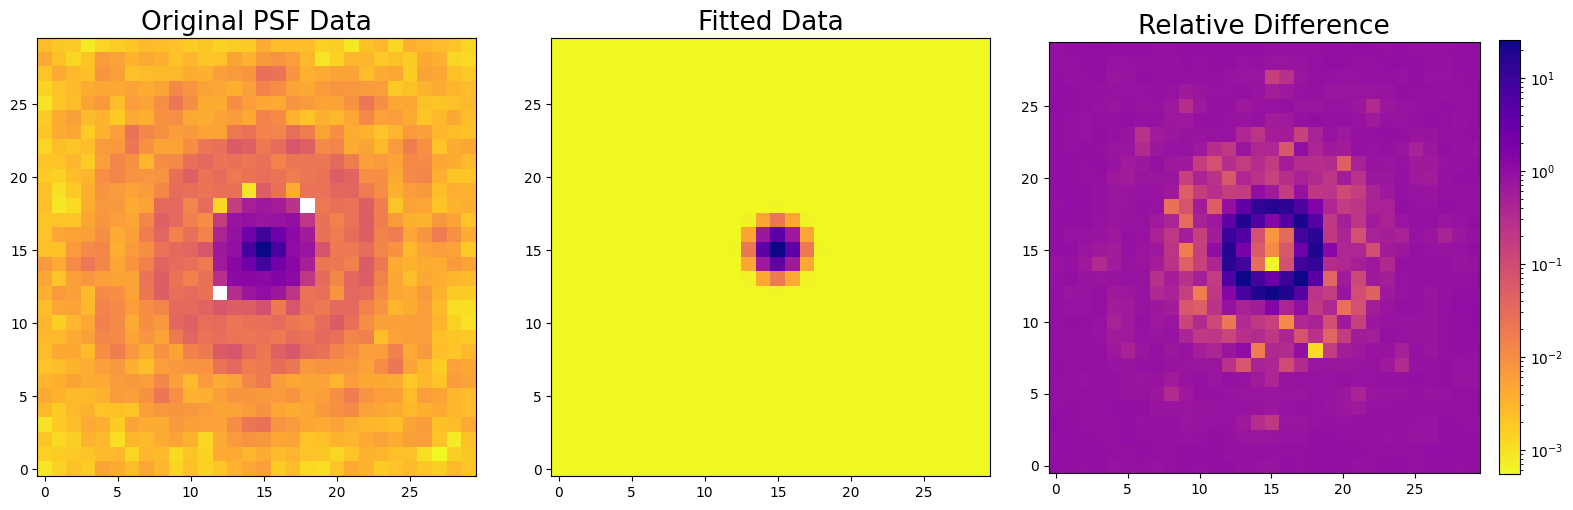

In [2]:
%matplotlib inline
with fits.open('psf/combined_psf/ERSPRIME_38832_hb.fits') as hdu:
        image_data = hdu[1].data
        popt = fit_gaussian_2d(hdu[1])
        print(popt)

        # Generate fitted data
        size_x, size_y = image_data.shape
        x = np.linspace(0, size_x - 1, size_x)
        y = np.linspace(0, size_y - 1, size_y)
        x, y = np.meshgrid(x, y)
        fitted_data = gaussian_2d(x, y, *popt)

        # Create a figure with multiple subplots in one row
        fig, axs = plt.subplots(1, 3, figsize=(16, 5))

        # Plot original data
        im0 = axs[0].imshow(image_data, origin='lower', cmap='plasma_r', norm=colors.LogNorm())
        axs[0].set_title('Original PSF Data', fontsize=19)
        #fig.colorbar(im0, ax=axs[0], fraction=0.046, pad=0.04)

        # Plot fitted data
        im1 = axs[1].imshow(fitted_data, origin='lower', cmap='plasma_r', norm=colors.LogNorm())
        axs[1].set_title('Fitted Data', fontsize=19)
        #fig.colorbar(im1, ax=axs[1], fraction=0.046, pad=0.04)

        # Plot relative difference
        im2 = axs[2].imshow(np.abs(fitted_data - image_data) / fitted_data, origin='lower', cmap='plasma_r',norm=colors.LogNorm())
        axs[2].set_title('Relative Difference', fontsize=19)

        fig.colorbar(im2, ax=axs[2], fraction=0.046, pad=0.04)

        plt.tight_layout()
        plt.savefig('image_outputs/psf_fit.jpg')
        plt.show()

### fit gaussian to psfs and check FWHM

  0%|          | 0/545 [00:00<?, ?it/s]

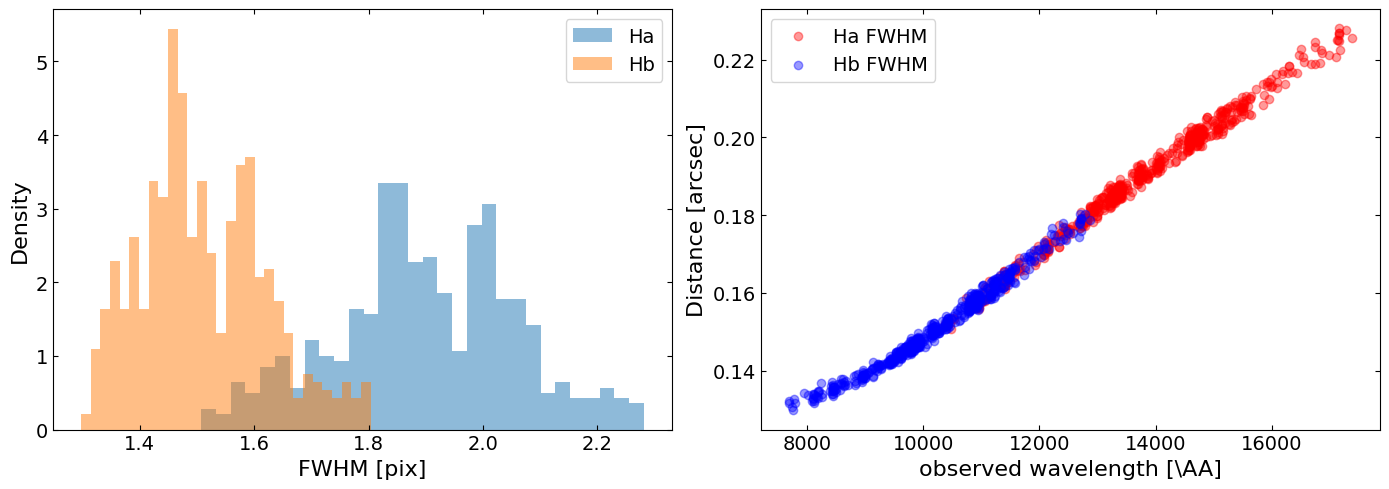

In [3]:
# compute fwhm for psfs and kernels of one object and compare
def psf_check(obj,
              window=match.CosineBellWindow,
              alpha=0.5,beta=0.9):
    
    #matching kernel and fit 2d gaussian
    #path for combined psf
    path_to_psf = f"psf/combined_psf/{obj['subfield']}_{obj['id']}"

    #open and update extracted file, add psf_kernel
    psf_ha = fits.open(f'{path_to_psf}_ha.fits')[1]
    psf_hb = fits.open(f'{path_to_psf}_hb.fits')[1]
    kernel = gen_kernel(psf_hb,psf_ha,window,alpha,beta)
    popt_kernel = fit_gaussian_2d(kernel)
    kernel.writeto(f"psf/matching_kernel/{obj['subfield']}_{obj['id']}.fits",overwrite=True)

    #load psf images and fit 2d gaussian
    hdu_ha = fits.open(f"psf/combined_psf/{obj['subfield']}_{obj['id']}_ha.fits")[1]
    popt_ha = fit_gaussian_2d(hdu_ha)

    hdu_hb = fits.open(f"psf/combined_psf/{obj['subfield']}_{obj['id']}_hb.fits")[1]
    popt_hb = fit_gaussian_2d(hdu_hb)


    #for hb images we also need to convolve with the matching kernel and check the fwhm
    hb_kernel_convolved = fits.ImageHDU(data = convolve_fft(hdu_hb.data,kernel.data),
                                                header=hdu_hb.header, name= 'HB_kernel_CONV')
    popt_hb_convolved   = fit_gaussian_2d(hb_kernel_convolved)
    return [obj['subfield'],obj['id'],*popt_ha, *popt_hb,*popt_kernel,*popt_hb_convolved]

#call psf_fit function, cat process, gen fit results table
def cat_process_psf_fit(
        window=match.CosineBellWindow,
        alpha=0.5,beta=0.9):
        col_names = ['subfield','id',
                    'amplitude_ha', 'fwhm_ha', 'x0_ha', 'y0_ha', 'c_ha', 
                    'amplitude_hb', 'fwhm_hb', 'x0_hb', 'y0_hb', 'c_hb', 
                    'amplitude_kernel', 'fwhm_kernel', 'x0_kernel', 'y0_kernel', 'c_kernel',
                    'amplitude_hb_conv', 'fwhm_hb_conv', 'x0_hb_conv', 'y0_hb_conv', 'c_hb_conv']
        
        obj_lis = Table.read('obj_lis_selected.fits')
        keep = obj_lis['manual_select']=='keep'
        rows = []
        for obj in tqdm(obj_lis):
            try:
                rows.append(psf_check(obj,window,alpha,beta))
            except Exception as e:
                print(f"Error processing object {obj['subfield']}_{obj['id']}: {e}")
                continue
        fitresults = Table(rows=rows,names=col_names)
        fitresults.write('psf/psf_initial_fitresults.fits',overwrite=True)
        return fitresults

def main():
    obj_lis = Table.read('obj_lis_selected.fits')
    keep = obj_lis['manual_select']=='keep'
    #plot fwhm of psf_ha, psf_hb and psf_hb_convolved
    #initial test waith just a limit waindow width alpha=1
    psf_results = cat_process_psf_fit(alpha=1)
    fwhm_diff   = psf_results['fwhm_ha'] - psf_results['fwhm_hb']
    fig, axs = plt.subplots(1, 2, figsize=(14, 5))

    axs[0].hist(psf_results['fwhm_ha'], bins=30, density=True, alpha=0.5, label='Ha')
    axs[0].hist(psf_results['fwhm_hb'], bins=30, density=True, alpha=0.5, label='Hb')
    axs[0].set_xlabel('FWHM [pix]', fontsize=16)
    axs[0].set_ylabel('Density', fontsize=16)
    axs[0].legend(fontsize=14)
    axs[0].tick_params(axis='both', which='major', labelsize=14)
    axs[0].tick_params(axis='both', which='both', direction='in', top=True, right=True)

    # Build x-axis arrays that match psf_results
    z_map = []
    for subfield, obj_id in zip(psf_results['subfield'], psf_results['id']):
        mask = (obj_lis['subfield'] == subfield) & (obj_lis['id'] == obj_id)
        z_map.append(obj_lis['z_MAP'][mask][0])
    z_map = np.array(z_map)

    axs[1].scatter((z_map+1)*(6563), psf_results['fwhm_ha']*0.1, label='Ha FWHM', color='r',alpha=0.4)
    axs[1].scatter((z_map+1)*(4861), psf_results['fwhm_hb']*0.1, label='Hb FWHM', color='b',alpha=0.4)
    axs[1].set_xlabel(r'observed wavelength [\AA]', fontsize=16)
    axs[1].set_ylabel('Distance [arcsec]', fontsize=16)
    axs[1].legend(fontsize=14)
    axs[1].tick_params(axis='both', which='major', labelsize=14)
    axs[1].tick_params(axis='both', which='both', direction='in', top=True, right=True)

    plt.tight_layout()
    plt.savefig('image_outputs/psf_comparison.jpg')
    plt.show()

    '''
    alphas = np.linspace(1.8,5,4)
    for alpha in alphas:
        psf_results = cat_process_psf_fit(alpha=alpha)
        plt.plot(psf_results['fwhm_hb_conv'],psf_results['fwhm_ha'],marker='.',linewidth=0,label=f'alpha={round(alpha,2)}')

    psf_results = cat_process_psf_fit(window=match.TopHatWindow,alpha=2)
    plt.plot(psf_results['fwhm_hb_conv'],psf_results['fwhm_ha'],marker='.',linewidth=0,label='no window')
    
    plt.plot([1.55,2.5],[1.55,2.5])
    plt.xlabel('fwhm psf hb_convolved');plt.ylabel('fwhm ha_psf')
    plt.legend();plt.grid();plt.show()
    '''
if __name__ == '__main__':
    main()

  0%|          | 0/545 [00:00<?, ?it/s]

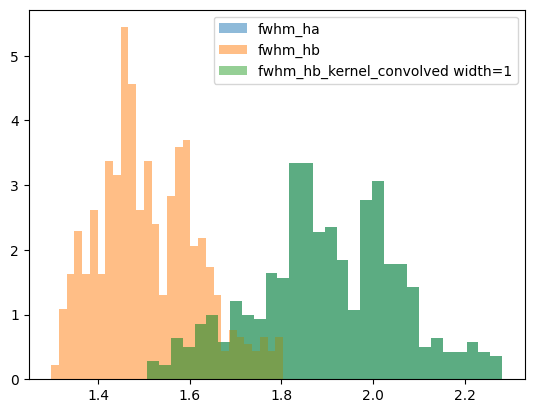

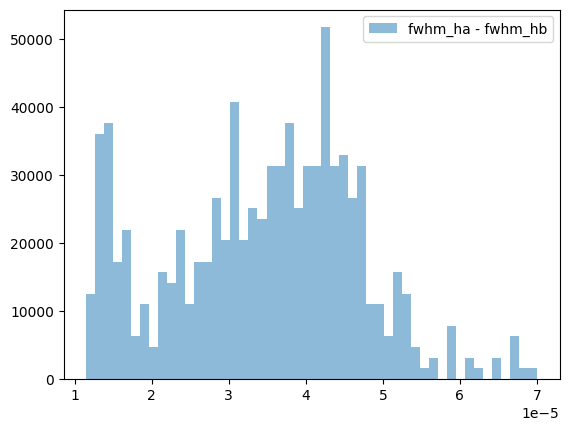

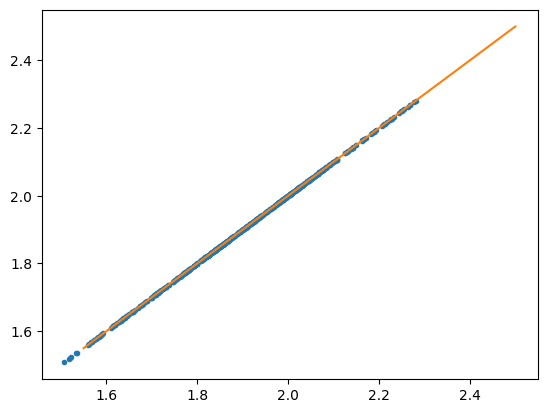

In [4]:
psf_results = cat_process_psf_fit(window=None, beta=0.4,alpha=10)
fwhm_diff   = psf_results['fwhm_hb_conv'] - psf_results['fwhm_ha']
plt.hist(psf_results['fwhm_ha']     ,bins=30,density=True,alpha=0.5,label='fwhm_ha')
plt.hist(psf_results['fwhm_hb']     ,bins=30,density=True,alpha=0.5,label='fwhm_hb')
plt.hist(psf_results['fwhm_hb_conv'],bins=30,density=True,alpha=0.5,label='fwhm_hb_kernel_convolved width=1')
plt.legend();plt.show()
plt.hist(fwhm_diff ,bins=50,density=True,alpha=0.5,label='fwhm_ha - fwhm_hb')
plt.legend();plt.show()
plt.plot(psf_results['fwhm_hb_conv'],psf_results['fwhm_ha'],marker='.',linewidth=0)
plt.plot([1.55,2.5],[1.55,2.5])


### best matching kernel: no windows

In [9]:
obj_lis = Table.read('obj_lis_selected.fits')
index = 2

def plot_psf(obj):
        path_to_psf = f"psf/combined_psf/{obj['subfield']}_{obj['id']}"
        psf_ha = fits.open(f'{path_to_psf}_ha.fits')[1]
        psf_hb = fits.open(f'{path_to_psf}_hb.fits')[1]
        window = None
        kernel = fits.ImageHDU(
                data=match.create_matching_kernel(psf_hb.data, psf_ha.data, window=window),
                name='PSF_MATCH'
        )
        kernel.data = kernel.data / np.sum(kernel.data)
        psf_hb_conv = fits.ImageHDU(data=convolve_fft(psf_hb.data, kernel.data), header=psf_hb.header, name='HB_kernel_CONV')

        plt.imshow(np.abs(psf_hb_conv.data - psf_ha.data) / psf_ha.data, cmap='plasma_r', norm=colors.LogNorm())
        plt.title('Relative Difference', fontsize=24)
        plt.colorbar()
        plt.tick_params(labelbottom=False, labelleft=False, bottom=True, top=True, left=True, right=True, labelsize=16)
        plt.savefig(f"psf/fit_results/{obj['subfield']}_{obj['id']}_diff")
        plt.show()
        plt.close()

        # Create a figure with multiple subplots
        fig, axs = plt.subplots(1, 4, figsize=(20, 5))

        # Plot kernel
        im1 = axs[0].imshow(kernel.data, cmap='plasma_r', norm=colors.LogNorm())
        axs[0].set_title('Kernel', fontsize=24)
        fig.colorbar(im1, ax=axs[0], fraction=0.046, pad=0.04)
        axs[0].tick_params(labelbottom=False, labelleft=False, bottom=True, top=True, left=True, right=True, labelsize=16)

        # Plot ha
        im2 = axs[1].imshow(psf_ha.data, cmap='plasma_r', norm=colors.LogNorm())
        axs[1].set_title('Ha', fontsize=24)
        fig.colorbar(im2, ax=axs[1], fraction=0.046, pad=0.04)
        axs[1].tick_params(labelbottom=False, labelleft=False, bottom=True, top=True, left=True, right=True, labelsize=16)

        # Plot hb
        im3 = axs[2].imshow(psf_hb.data, cmap='plasma_r', norm=colors.LogNorm())
        axs[2].set_title('Hb', fontsize=24)
        fig.colorbar(im3, ax=axs[2], fraction=0.046, pad=0.04)
        axs[2].tick_params(labelbottom=False, labelleft=False, bottom=True, top=True, left=True, right=True, labelsize=16)

        # Plot hb_conv
        im4 = axs[3].imshow(psf_hb_conv.data, cmap='plasma_r', norm=colors.LogNorm())
        axs[3].set_title('Hb Convolved', fontsize=24)
        fig.colorbar(im4, ax=axs[3], fraction=0.046, pad=0.04)
        axs[3].tick_params(labelbottom=False, labelleft=False, bottom=True, top=True, left=True, right=True, labelsize=16)

        # Adjust layout
        plt.tight_layout()
        plt.savefig(f"psf/fit_results/{obj['subfield']}_{obj['id']}")
        plt.show()
        clear_output(wait=True)
        return f"{obj['subfield']}_{obj['id']} plotted"

keep = obj_lis['manual_select']=='keep'
for obj in tqdm(obj_lis[keep]):
        plot_psf(obj)


100%|██████████| 319/319 [04:14<00:00,  1.26it/s]


#### Here I found that without window filtering the kernels gives the most sensible result

#  matching psf + hb convolving with optimized parameter (i.e. no window function)

In [3]:
#find specific entry in the hdu

#this small fucntion will save the updated image to the extracted file 
def save_update(image_to_save,extracted):
        for i,image in enumerate(extracted):
            if image.name == image_to_save.name:
                extracted[i] = image_to_save
                return extracted
        extracted.append(image_to_save)
        extracted.flush()
        return extracted

def match_psf(obj):
    try:
        #print(obj)
        #path for extracted hdu list and combined psf
        path        = f"data_extracted/{file_name(obj,prefix='extracted')}"
        path_to_psf = f"psf/combined_psf/{obj['subfield']}_{obj['id']}"

        #open and update extracted file, add psf_kernel
        with fits.open(path,mode='update') as extracted:

            #check if datas already exists in extracted file
            if find_data('PSF_MATCH',extracted) != None and find_data('LINE_HB_CONV',extracted) != None and find_data('LINEWHT_HB_CONV',extracted) != None:
                #clear_output(wait=True)
                #print(f"{obj['subfield']}_{obj['id']} already processed")
                return f"{obj['subfield']}_{obj['id']} already processed"

            psf_ha = fits.open(f'{path_to_psf}_ha.fits')[1]
            psf_hb = fits.open(f'{path_to_psf}_hb.fits')[1]
            kernel = gen_kernel(psf_hb,psf_ha,window=None)
            
            #convolve hb linemap
            hb     = find_data('LINE_HB',extracted)[1]
            hb_convolve = fits.ImageHDU(data = convolve_fft(hb.data,kernel.data),
            header = hb.header,name = 'LINE_HB_CONV')

            #cnvolve hb weight map
            hb_wht = find_data('LINEWHT_HB',extracted)[1]
            hb_wht_convolve = fits.ImageHDU(data = convolve_fft(hb_wht.data,kernel.data),
            header = hb_wht.header,name = 'LINEWHT_HB_CONV')

            #also do a background subtraction for the convoled image
            hb_convolve_bg = fits.ImageHDU(data = hb_convolve.data - np.median(hb_convolve.data),
            header = hb.header,name = 'LINE_HB_CONV_BG')

            # either update or add data to HDUlist
            save_update(kernel          ,extracted)
            save_update(hb_convolve     ,extracted)
            save_update(hb_wht_convolve ,extracted)
            save_update(hb_convolve_bg  ,extracted)

            #clear_output(wait=True)
            return f"{obj['subfield']}_{obj['id']} processed"
    except Exception as e:
            return f"! {obj['subfield']}-{obj['ID']} failed, error{e}"


from concurrent.futures     import ThreadPoolExecutor, as_completed
def cat_process_match_psf(obj_lis,max_threads=1):
    results = []
    if max_threads>1:
        with ThreadPoolExecutor(max_threads) as executor:
            futures = {executor.submit(match_psf,obj):obj for obj in obj_lis}
            for future in tqdm(as_completed(futures), total=len(obj_lis), desc="Processing"):
                results.append(future.result())
        return results
    else:
        for obj in tqdm(obj_lis):
            results.append(match_psf(obj))
        return results

if __name__ == '__main__':
    obj_lis = Table.read('obj_lis_selected.fits')
    results = cat_process_match_psf(obj_lis,max_threads=15)
    number = 0
    for result in results:
        if 'error' in result:
            number +=1
            print(result)
    print('total number of obj processed:',len(results))
    print('number of failed obj',number)

Processing:   0%|          | 0/1424 [00:00<?, ?it/s]

/opt/anaconda3/envs/stenv/lib/python3.13/site-packages/photutils/psf/matching/fourier.py:88: RuntimeWarning: invalid value encountered in divide
  source_psf /= source_psf.sum()
/opt/anaconda3/envs/stenv/lib/python3.13/site-packages/photutils/psf/matching/fourier.py:89: RuntimeWarning: invalid value encountered in divide
  target_psf /= target_psf.sum()
/opt/anaconda3/envs/stenv/lib/python3.13/site-packages/photutils/psf/matching/fourier.py:93: RuntimeWarning: invalid value encountered in divide
  ratio = target_otf / source_otf


! GN2-9948 failed, error[Errno 2] No such file or directory: 'psf/combined_psf/GN2_9948_ha.fits'
! GN7-11593 failed, error[Errno 2] No such file or directory: 'psf/combined_psf/GN7_11593_ha.fits'
! GN7-13093 failed, error[Errno 2] No such file or directory: 'psf/combined_psf/GN7_13093_ha.fits'
! GN7-13502 failed, error'NoneType' object is not subscriptable
! GN2-13640 failed, error'NoneType' object is not subscriptable
! GN2-14039 failed, error[Errno 2] No such file or directory: 'psf/combined_psf/GN2_14039_ha.fits'
! GN2-16096 failed, error[Errno 2] No such file or directory: 'psf/combined_psf/GN2_16096_ha.fits'
! GN2-17760 failed, error[Errno 2] No such file or directory: 'psf/combined_psf/GN2_17760_ha.fits'
! GN2-17977 failed, error[Errno 2] No such file or directory: 'psf/combined_psf/GN2_17977_ha.fits'
! GN2-20298 failed, error[Errno 2] No such file or directory: 'psf/combined_psf/GN2_20298_ha.fits'
! GN7-20333 failed, error[Errno 2] No such file or directory: 'psf/combined_psf/GN

In [19]:
import re
error_table = Table(names=['subfield', 'ID', 'error'], dtype=['str', 'str', 'str'])
number = 0
for result in results:
        if 'error' in result:
            number += 1

            # 修复正则表达式：error后面没有冒号，直接跟着错误信息
            m = re.match(r"! ([^-]+)-([^\s]+) failed, error(.*)", result)
            if m:
                subfield, id_, error = m.group(1), m.group(2), m.group(3)
            else:
                subfield, id_, error = '', '', result
            error_table.add_row([subfield, id_, error])
error_table.write('failed_objects.fits', overwrite=True)
print(error_table['ID'])
print('errored objects, potential data problem from the sever (bad data set)')
print('number of failed obj:', number)

#remove error objects from obj_lis
obj_lis = Table.read('obj_lis_selected.fits')
print('number of objects before removing errored objects:', len(obj_lis))

#remove errored objects from obj_lis
errored_ids = error_table['ID']
errored_subfields = error_table['subfield']
mask = np.ones(len(obj_lis), dtype=bool)
for i, row in enumerate(obj_lis):
    if (str(row['id']) in errored_ids.astype(str)) and (str(row['subfield']) in errored_subfields.astype(str)):
        mask[i] = False
obj_lis = obj_lis[mask]
print('number of objects after removing errored objects:', len(obj_lis))



  ID 
-----
 9948
11593
13093
13502
13640
14039
16096
17760
17977
20298
  ...
41461
41571
42684
43018
43266
43599
44459
44784
44842
46506
Length = 41 rows
errored objects, potential data problem from the sever (bad data set)
number of failed obj: 41
number of objects before removing errored objects: 1383
number of objects after removing errored objects: 1383


In [20]:
obj_lis.write('obj_lis_selected.fits',overwrite=True)